# Data statistics of the Singapore maritime dataset for the split data of the second generated dataset

This is a jupyter notebook to calculate some statistics of the Singapore maritime dataset as it was split into training and test datasets for every 5 frames.

Dataset available here: https://sites.google.com/site/dilipprasad/home/singapore-maritime-dataset

If this dataset is used please cite it as:

D. K. Prasad, D. Rajan, L. Rachmawati, E. Rajabaly, and C. Quek, "Video Processing from Electro-optical Sensors for Object Detection and Tracking in Maritime Environment: A Survey," IEEE Transactions on Intelligent Transportation Systems (IEEE), 2017. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import colorsys
import pandas as pd
import os

Get the frames that exist in both training and test dataset folders.

In [2]:
SEPARATE_FOLDERS = False # there are separate folders under train/test or all images are in train/test dirs

TRAIN_PATH = './train_2'
TEST_PATH = './test_2'

if SEPARATE_FOLDERS:
    train_folders = [os.path.join(TRAIN_PATH, directory) for directory in os.listdir(TRAIN_PATH) 
                           if os.path.isdir(os.path.join(TRAIN_PATH, directory))]
    test_folders = [os.path.join(TEST_PATH, directory) for directory in os.listdir(TEST_PATH) 
                           if os.path.isdir(os.path.join(TEST_PATH, directory))]

    train_frames = []
    for folder in train_folders:
        train_frames = train_frames + [os.path.join(folder, f) for f in os.listdir(folder)
                           if os.path.isfile(os.path.join(folder, f))]

    test_frames = []
    for folder in test_folders:
        test_frames = test_frames + [os.path.join(folder, f) for f in os.listdir(folder)
                           if os.path.isfile(os.path.join(folder, f))]
        
else:
    train_frames = [os.path.join(TRAIN_PATH, f) for f in os.listdir(TRAIN_PATH)
                       if os.path.isfile(os.path.join(TRAIN_PATH, f))]

    test_frames = [os.path.join(TEST_PATH, f) for f in os.listdir(TEST_PATH)
                       if os.path.isfile(os.path.join(TEST_PATH, f))]

    
total_frames = len(train_frames) + len(test_frames)
print("Total number of training frames is %d and represent %f of total frames." 
                      % (len(train_frames), len(train_frames) / total_frames))
print("Total number of test frames is %d and represent %f of total frames." 
                      % (len(test_frames), len(test_frames) /total_frames))

Total number of training frames is 4169 and represent 0.656535 of total frames.
Total number of test frames is 2181 and represent 0.343465 of total frames.


First lets load the object ground truth from the pre-calculated text files.

In [3]:
objects_onshore = []
with open("objects_onshore.txt") as f:
    for line in f: 
        line = line.strip()
        objects_onshore.append(line)
        
objects_onboard = []
with open("objects_onboard.txt") as f:
    for line in f: 
        line = line.strip()
        objects_onboard.append(line)
        
objects_nir = []
with open("objects_nir.txt") as f:
    for line in f: 
        line = line.strip()
        objects_nir.append(line)
        
print("Example entry of ground truth files:")
print(objects_onboard[0])

Example entry of ground truth files:
MVI_0797_VIS_OB_frame0.jpg,1327.534834324554,459.75233644859804,161.49532710280369,42.412914188615105,3,2,1


The form of each line/entry is:

[video_name] _ [frame_number] ,minimum x, minimum y, object width, object height, type of object, distance of object, type of motion of object

Further description can be found here (https://drive.google.com/file/d/0B10RxHxW3I92NjRjZnN1bjVjelk/view).

We only need to keep entries that are rellevant to the frames we use for training and testing. Let's select these entries.

In [4]:
# This is TOO slow!! Run next cell instead

# object_list_full = objects_onshore + objects_onboard + objects_nir

# train_objects = []
# for file in train_frames:
#     name = file.split('/')[-1]
    
#     for entry in object_list_full:
#         entry_filename = entry.split(',')[0]
#         if entry_filename == name:
#             train_objects.append(entry)
                
# print(train_objects)

In [4]:
object_list_full = objects_onshore + objects_onboard + objects_nir

train_filenames = []
for file in train_frames:
    train_filenames.append(file.split('/')[-1])

train_objects = []
for entry in object_list_full:
    entry_filename = entry.split(',')[0]
    if entry_filename in train_filenames:
        train_objects.append(entry)
                
test_filenames = []
for file in test_frames:
    test_filenames.append(file.split('/')[-1])
    
test_objects = []
for entry in object_list_full:
    entry_filename = entry.split(',')[0]
    if entry_filename in test_filenames:
        test_objects.append(entry)

In [5]:
print('Number of objects in train dataset frames: %d' % len(train_objects))
print('Number of objects in test dataset frames: %d' % len(test_objects))

Number of objects in train dataset frames: 32597
Number of objects in test dataset frames: 15720


# Dictionaries for the object type, motion and dictance.

Now lets create the dictionaries for the object type, motion and dictance and unique colours for each of them.

In [6]:
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

Set some dictionaries specifit to SMD.

In [7]:
object_type_dict = {
    1:'Ferry',
    2:'Buoy',
    3:'Vessel/ship',
    4:'Speed boat',
    5:'Boat',
    6:'Kayak',
    7:'Sail boat',
    8:'Swimming person',
    9:'Flying bid/plane',
    10:'Other'
}

object_motion_dict = {
    1:'Moving',
    2:'Stationary',
    3:'Other'
}

object_distance_dict = {
    1:'Near',
    2:'Far',
    3:'Other'
}

object_colours_list = get_colors(len(object_type_dict))

# Generate object size histograms for the train and test datasets

In [8]:
FIGURE_SAVE_PATH = './figures_split_2'

In [9]:
# the dimensions of the images are predefined to 1920*1080
image_height = 1080
image_width = 1920

number_of_objects_train = len(train_objects) # 34376
number_of_objects_test = len(test_objects) # 13941

obj_height_train = np.zeros([number_of_objects_train])
obj_width_train = np.zeros([number_of_objects_train])
obj_area_train = np.zeros([number_of_objects_train])

obj_height_test = np.zeros([number_of_objects_test])
obj_width_test = np.zeros([number_of_objects_test])
obj_area_test = np.zeros([number_of_objects_test])

In [10]:
for i, obj in enumerate(train_objects):
    data = obj.split(',')
    obj_width_train[i] = float(data[3])
    obj_height_train[i] = float(data[4])
    
obj_area_train = obj_width_train * obj_height_train

for i, obj in enumerate(test_objects):
    data = obj.split(',')
    obj_width_test[i] = float(data[3])
    obj_height_test[i] = float(data[4])
    
obj_area_test = obj_width_test * obj_height_test

In [11]:
# scale them based on the image size
obj_width_ratio_train = obj_width_train.copy() / image_width
obj_height_ratio_train = obj_height_train.copy() / image_height
obj_area_ratio_train = obj_area_train.copy() / (image_height * image_width)

obj_width_ratio_test = obj_width_test.copy() / image_width
obj_height_ratio_test = obj_height_test.copy() / image_height
obj_area_ratio_test = obj_area_test.copy() / (image_height * image_width)

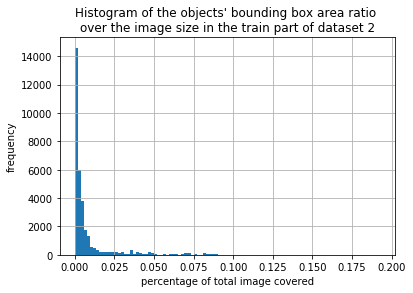

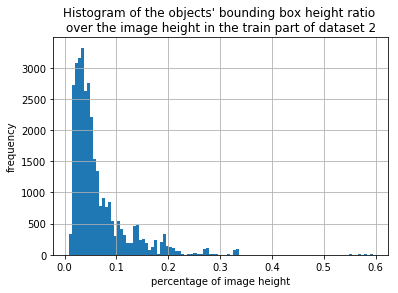

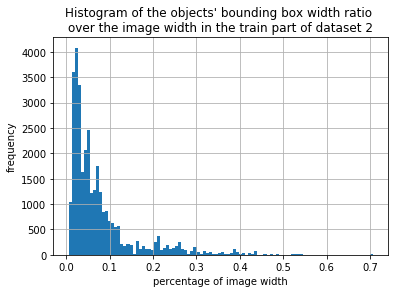

In [13]:
plt.hist(obj_area_ratio_train, bins=100)
plt.title("Histogram of the objects' bounding box area ratio \nover the image size in the train part of dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of total image covered")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_area_train.jpg"), tight_layout=True, dpi=300)
plt.show()

plt.hist(obj_height_ratio_train, bins=100)
plt.title("Histogram of the objects' bounding box height ratio \nover the image height in the train part of dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of image height")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_height_train.jpg"), tight_layout=True, dpi=300)
plt.show()

plt.hist(obj_width_ratio_train, bins=100)
plt.title("Histogram of the objects' bounding box width ratio \nover the image width in the train part of dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of image width")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_width_train.jpg"), tight_layout=True, dpi=300)
plt.show()

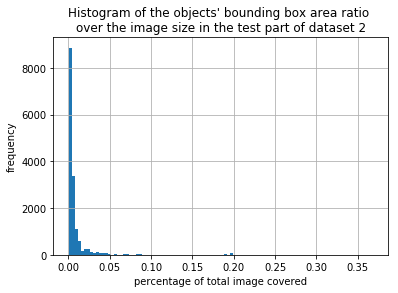

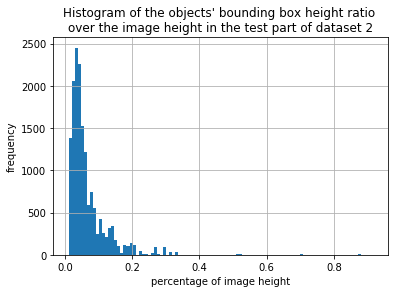

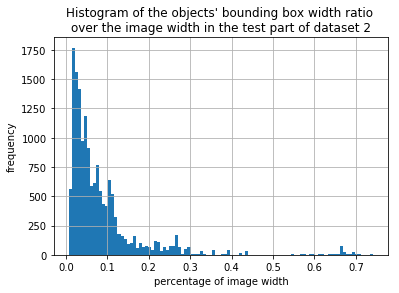

In [14]:
plt.hist(obj_area_ratio_test, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of the objects' bounding box area ratio \nover the image size in the test part of dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of total image covered")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_area_test.jpg"), tight_layout=True, dpi=300)
plt.show()

plt.hist(obj_height_ratio_test, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of the objects' bounding box height ratio \nover the image height in the test part of dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of image height")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_height_test.jpg"), tight_layout=True, dpi=300)
plt.show()

plt.hist(obj_width_ratio_test, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of the objects' bounding box width ratio \nover the image width in the test part of dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of image width")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_width_test.jpg"), tight_layout=True, dpi=300)
plt.show()

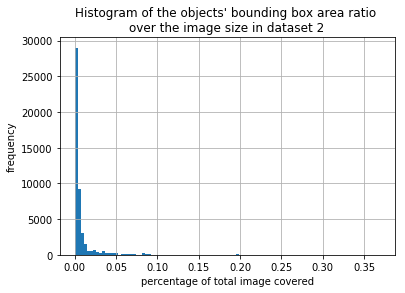

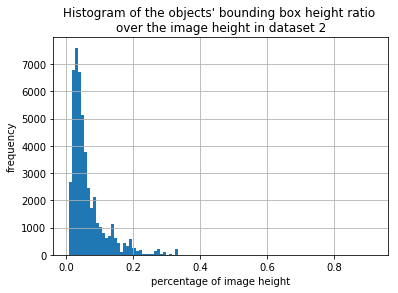

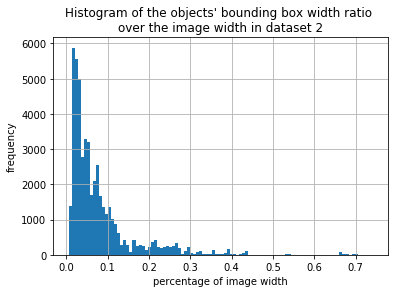

In [15]:
plt.hist(np.vstack([obj_area_ratio_train[:,np.newaxis], obj_area_ratio_test[:,np.newaxis]]), bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of the objects' bounding box area ratio \nover the image size in dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of total image covered")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_area_whole_split_dataset.jpg"), tight_layout=True, dpi=300)
plt.show()

plt.hist(np.vstack([obj_height_ratio_train[:,np.newaxis], obj_height_ratio_test[:,np.newaxis]]), bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of the objects' bounding box height ratio \nover the image height in dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of image height")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_height_whole_split_dataset.jpg"), tight_layout=True, dpi=300)
plt.show()

plt.hist(np.vstack([obj_width_ratio_train[:,np.newaxis], obj_width_ratio_test[:,np.newaxis]]), bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of the objects' bounding box width ratio \nover the image width in dataset 2")
plt.ylabel("frequency")
plt.xlabel("percentage of image width")
plt.grid()
plt.savefig(os.path.join(FIGURE_SAVE_PATH, "histogram_width_whole_split_dataset.jpg"), tight_layout=True, dpi=300)
plt.show()

# Frequency and ratio of objects' type/motion/distance in the datasets

Calculate the frequency and ratio of objects in the dataset and generate appropriate graphs.

In [16]:
number_of_objects_train = len(train_objects)
number_of_objects_test = len(test_objects)

# create empty numpy arrays to accommodate all relevant data
objects_type_train = np.empty([number_of_objects_train])
objects_type_test = np.empty([number_of_objects_test])

objects_motion_train = np.empty([number_of_objects_train])
objects_motion_test = np.empty([number_of_objects_test])

objects_distance_train = np.empty([number_of_objects_train])
objects_distance_test = np.empty([number_of_objects_test])

In [17]:
# iterate and gather relevant data
for i, obj in enumerate(train_objects):
    data = obj.split(',')
    objects_type_train[i] = int(data[5])
    objects_motion_train[i] = int(data[6])
    objects_distance_train[i] = int(data[7])
    
for i, obj in enumerate(test_objects):
    data = obj.split(',')
    objects_type_test[i] = int(data[5])
    objects_motion_test[i] = int(data[6])
    objects_distance_test[i] = int(data[7])

lets generate the relevant data for all dataset

In [18]:
objects_type_total = np.vstack((objects_type_train[:,np.newaxis], objects_type_test[:,np.newaxis]))

objects_distance_total = np.vstack((objects_distance_train[:,np.newaxis], objects_distance_test[:,np.newaxis]))

objects_motion_total = np.vstack((objects_motion_train[:,np.newaxis], objects_motion_test[:,np.newaxis]))

In [19]:
unique, counts = np.unique(objects_type_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[1.0000e+00 1.3800e+03]
 [2.0000e+00 5.3100e+02]
 [3.0000e+00 2.3658e+04]
 [4.0000e+00 1.1080e+03]
 [5.0000e+00 1.5000e+02]
 [6.0000e+00 6.3300e+02]
 [7.0000e+00 3.5700e+02]
 [9.0000e+00 1.3200e+02]
 [1.0000e+01 4.6480e+03]]


In [20]:
def generate_unique_values_histogram(x):
    """
    Helper function to count unique entries in an array and each entry's count.
    """
    unique, counts = np.unique(x, return_counts=True)
    return unique, counts

# Charts of object type/motion/distance frequency in the train/test datasets

In this section the frequencies of the objects' type, motion and distance will be given in nice graphs

In [21]:
def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

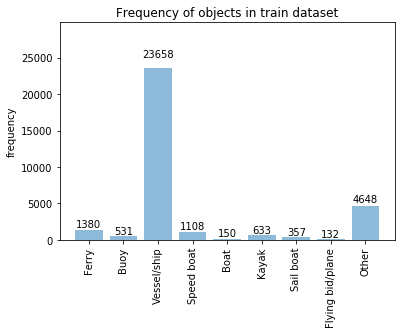

In [22]:
# Example plot

train_object_type_values, train_object_type_counts = generate_unique_values_histogram(objects_type_train)
 
objects_labels = []
for i in train_object_type_values:
    objects_labels.append(object_type_dict[int(i)])

y_pos = np.arange(len(objects_labels))
#performance = [10,8,6,4,2,1]
 
rects = plt.bar(y_pos, train_object_type_counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects_labels, rotation='vertical')
plt.ylabel('frequency')
plt.title('Frequency of objects in train dataset')

autolabel(plt, rects)
plt.ylim(top=plt.ylim()[1]+5000)
 
plt.show()

In [23]:
def draw_bar_chart(x, x_dict, title, file_name='', vertical_x_labels=False):
    """
    This function generates a bar chart for the Singapore Maritime Dataset based on the paramaters given.
    
    Parameters
    ----------
    
    x : the data to be used. It is a 1d numpy array with integer values.
    
    x_dict : the dictionary with the corresponding string values of the x.
                example: x_dict[x[0]] = 'corresponding string for value in x[0]'
    
    title: title of the chart. (string)
    
    file_name : the filename to save the figure. If left as empty string the figure will no be saved. 
                Default: empty string.
    
    vertical_x_labels : should the xticks labels be drawn vertical? (boolean)
                Default: False
    """
    values, counts = generate_unique_values_histogram(x)
    
    labels = []
    for i in values:
        labels.append(x_dict[int(i)])

    y_pos = np.arange(len(labels))

    plt.figure()
    plt.bar(y_pos, counts, align='center', alpha=0.5)
    if vertical_x_labels:
        plt.xticks(y_pos, labels, rotation='vertical')
    else:
        plt.xticks(y_pos, labels)
    plt.ylabel('frequency')
    plt.title(title)
    
    if file_name != '':
        plt.savefig(file_name)
    plt.show()

In [24]:
def draw_bar_chart_subplot(ax, x, x_dict, title, vertical_x_labels=False, colour_list=None):
    """
    This function generates a bar chart for the Singapore Maritime Dataset based on the paramaters given.
    
    Parameters
    ----------
    
    ax : matplotlib.axes.Axes object.
    
    x : the data to be used. It is a 1d numpy array with integer values.
    
    x_dict : the dictionary with the corresponding string values of the x.
                example: x_dict[x[0]] = 'corresponding string for value in x[0]'
    
    title: title of the chart. (string)
    
    vertical_x_labels : should the xticks labels be drawn vertical? (boolean)
                Default: False
                
    colour_list : a list with colour for each x (unique) value. If set to None then all bars will be blue.
                Default: None
    """
    values, counts = generate_unique_values_histogram(x)
    
    labels = []
    for i in values:
        labels.append(x_dict[int(i)])

    y_pos = np.arange(len(labels))
    
    barlist = ax.bar(y_pos, counts, align='center', alpha=0.5)
    
    if colour_list is not None:
        # set colours
        for i, value in enumerate(values):
            barlist[i].set_color(colour_list[int(value-1)])
    
    autolabel(ax, barlist)
    ax.set_ylim(top=ax.get_ylim()[1]+9000)
    
    if vertical_x_labels:
        ax.set_xticks(y_pos)
        ax.set_xticklabels(labels, rotation='vertical')
    else:
        ax.set_xticks(y_pos)
        ax.set_xticklabels(labels)
    ax.set_ylabel('frequency')
    ax.set_title(title)

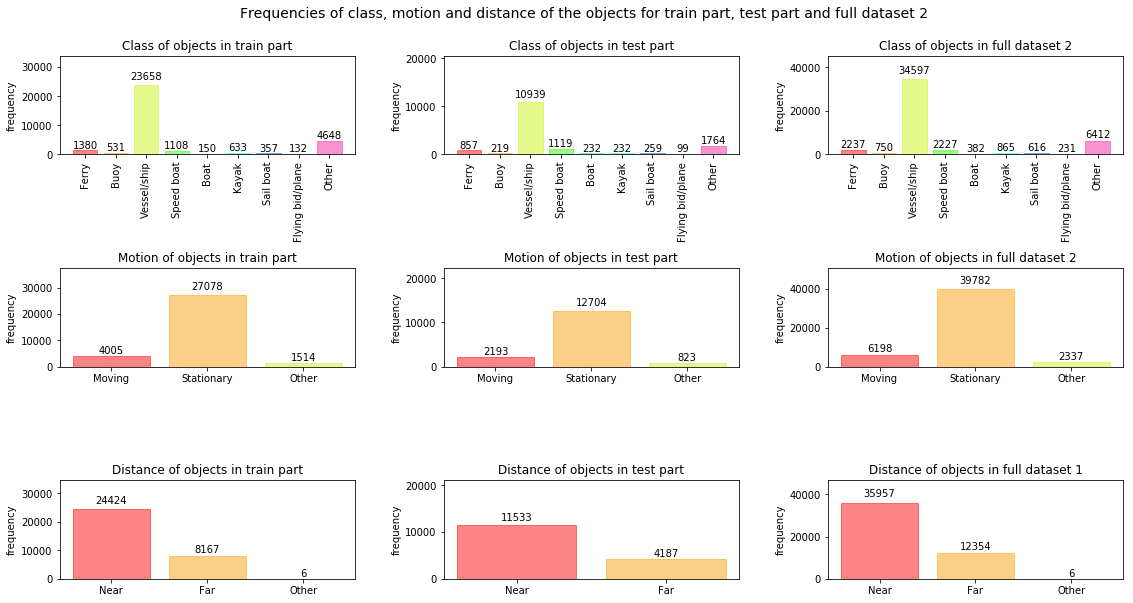

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(15.5, 8.5)
plt.tight_layout()

plt.subplots_adjust(top=0.9) # to include title on TOP of figure. Otherwise it overlaps due to tight_layout

fig.subplots_adjust(wspace=0.3,hspace=1.15)

draw_bar_chart_subplot(ax[0,0], objects_type_train, object_type_dict, 'Class of objects in train part', True, object_colours_list)
draw_bar_chart_subplot(ax[0,1], objects_type_test, object_type_dict, 'Class of objects in test part', True, object_colours_list)
draw_bar_chart_subplot(ax[0,2], objects_type_total, object_type_dict, 'Class of objects in full dataset 2', True, object_colours_list)

#TODO: remove colorlist arguments from these??
draw_bar_chart_subplot(ax[1,0], objects_motion_train, object_motion_dict, "Motion of objects in train part", False, object_colours_list)
draw_bar_chart_subplot(ax[1,1], objects_motion_test, object_motion_dict, "Motion of objects in test part", False, object_colours_list)
draw_bar_chart_subplot(ax[1,2], objects_motion_total, object_motion_dict, "Motion of objects in full dataset 2", False, object_colours_list)

draw_bar_chart_subplot(ax[2,0], objects_distance_train, object_distance_dict, "Distance of objects in train part", False, object_colours_list)
draw_bar_chart_subplot(ax[2,1], objects_distance_test, object_distance_dict, "Distance of objects in test part", False, object_colours_list)
draw_bar_chart_subplot(ax[2,2], objects_distance_total, object_distance_dict, "Distance of objects in full dataset 1", False, object_colours_list)

fig.suptitle("Frequencies of class, motion and distance of the objects for train part, test part and full dataset 2", fontsize=14)

plt.savefig(os.path.join(FIGURE_SAVE_PATH, 'multiple_graphs.png'), bbox_inches='tight', dpi=300)
plt.show()

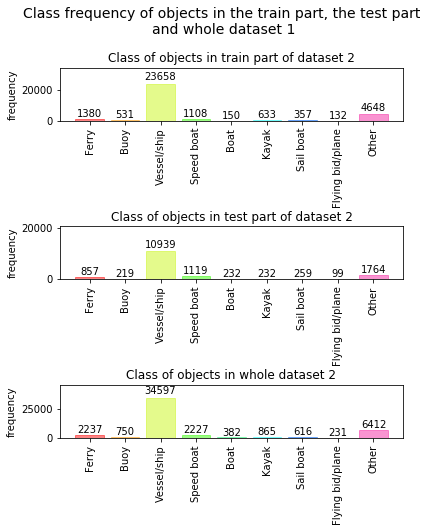

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(5.5, 6.5)
plt.tight_layout()

plt.subplots_adjust(top=0.85) # to include title on TOP of figure. Otherwise it overlaps due to tight_layout

fig.subplots_adjust(wspace=0.3,hspace=2.0)

draw_bar_chart_subplot(ax[0], objects_type_train, object_type_dict, 'Class of objects in train part of dataset 2', True, object_colours_list)
draw_bar_chart_subplot(ax[1], objects_type_test, object_type_dict, 'Class of objects in test part of dataset 2', True, object_colours_list)
draw_bar_chart_subplot(ax[2], objects_type_total, object_type_dict, 'Class of objects in whole dataset 2', True, object_colours_list)

fig.suptitle("Class frequency of objects in the train part, the test part \nand whole dataset 1", fontsize=14)

plt.savefig(os.path.join(FIGURE_SAVE_PATH, 'multiple_graphs_types.png'), bbox_inches='tight', dpi=300)
plt.show()

# Multi-bar plot for motion and distance of objects

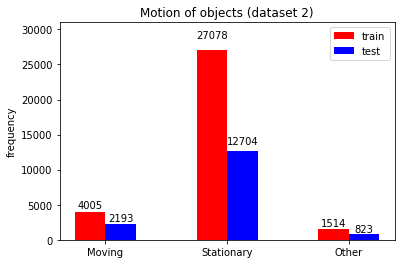

In [36]:
N = 3 # we have three motion types

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

values, counts = generate_unique_values_histogram(objects_motion_train)

fig, ax = plt.subplots()
rects1 = ax.bar(ind, counts, width, color='r')

values, counts = generate_unique_values_histogram(objects_motion_test)
rects2 = ax.bar(ind + width, counts, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('frequency')
ax.set_title('Motion of objects (dataset 2)')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((object_motion_dict[1], object_motion_dict[2], object_motion_dict[3]))

ax.legend((rects1[0], rects2[0]), ('train', 'test'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_ylim(top=31000)

plt.savefig(os.path.join(FIGURE_SAVE_PATH, 'object_motion_multibar.png'), bbox_inches='tight',dpi=300)
plt.show()

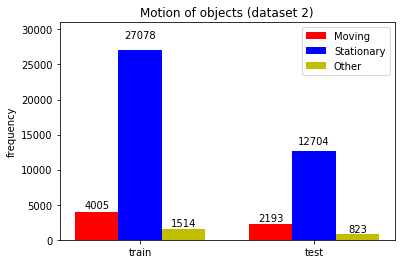

In [37]:
N = 2 # we have two dataset sources (train/test)

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

values, counts_train = generate_unique_values_histogram(objects_motion_train)
values, counts_test = generate_unique_values_histogram(objects_motion_test)

fig, ax = plt.subplots()
rects1 = ax.bar(ind, (counts_train[0], counts_test[0]), width, color='r')

rects2 = ax.bar(ind + width, (counts_train[1], counts_test[1]), width, color='b')

rects3 = ax.bar(ind + 2* width, (counts_train[2], counts_test[2]), width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('frequency')
ax.set_title('Motion of objects (dataset 2)')
ax.set_xticks(ind + width)
ax.set_xticklabels(('train', 'test'))

ax.legend((rects1[0], rects2[0], rects3[0]), (object_motion_dict[1], object_motion_dict[2], object_motion_dict[3]))

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.set_ylim(top=31000)

plt.savefig(os.path.join(FIGURE_SAVE_PATH, 'object_motion_multibar_2.png'), bbox_inches='tight',dpi=300)
plt.show()

In [33]:
def pad_missing_counts(counts):
    """
    Helper function to add missing zero entries for "other" type
    """
    if len(counts) < 3:
        counts = np.vstack([counts[:, np.newaxis],np.array([0])])[:,0]
        
    return counts

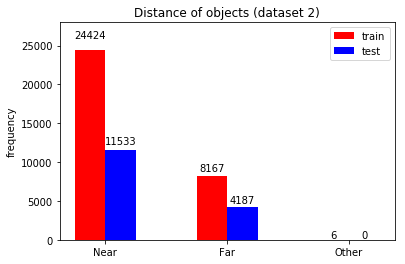

In [38]:
N = 3 # we have three distance types

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

values, counts = generate_unique_values_histogram(objects_distance_train)
counts = pad_missing_counts(counts)
fig, ax = plt.subplots()
rects1 = ax.bar(ind, counts, width, color='r')

values, counts = generate_unique_values_histogram(objects_distance_test)
counts = pad_missing_counts(counts)
rects2 = ax.bar(ind + width, counts, width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('frequency')
ax.set_title('Distance of objects (dataset 2)')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((object_distance_dict[1], object_distance_dict[2], object_distance_dict[3]))

ax.legend((rects1[0], rects2[0]), ('train', 'test'))

autolabel(rects1)
autolabel(rects2)

ax.set_ylim(top=28000)

plt.savefig(os.path.join(FIGURE_SAVE_PATH, 'object_distance_multibar.png'), bbox_inches='tight',dpi=300)
plt.show()

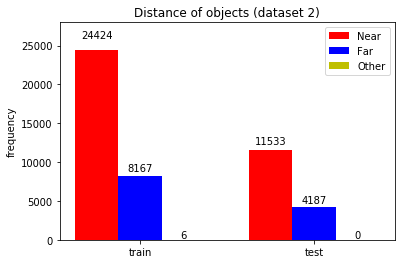

In [39]:
N = 2 # we have two datasets (train/test)

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

values, counts_train = generate_unique_values_histogram(objects_distance_train)
counts_train = pad_missing_counts(counts_train)
values, counts_test = generate_unique_values_histogram(objects_distance_test)
counts_test = pad_missing_counts(counts_test)

fig, ax = plt.subplots()
rects1 = ax.bar(ind, (counts_train[0], counts_test[0]), width, color='r')

rects2 = ax.bar(ind + width, (counts_train[1], counts_test[1]), width, color='b')

rects3 = ax.bar(ind + 2 * width, (counts_train[2], counts_test[2]), width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('frequency')
ax.set_title('Distance of objects (dataset 2)')
ax.set_xticks(ind + width)
ax.set_xticklabels(('train', 'test'))

ax.legend((rects1[0], rects2[0], rects3[0]), (object_distance_dict[1], object_distance_dict[2], object_distance_dict[3]))

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
ax.set_ylim(top=28000)

plt.savefig(os.path.join(FIGURE_SAVE_PATH, 'object_distance_multibar_2.png'), bbox_inches='tight',dpi=300)
plt.show()

# Statistics per video

Generate statistic for every video in order to see how the objects are spread.

solution based on: https://pstblog.com/2016/10/04/stacked-charts

Helper function need for the plotting.

In [40]:
# first get all unique videos from the ground truth files and their 
# corresponding frame numbers. Create a dictionary the form: <video_name>:<frame_count>

def get_unique_videos_dict(objects_list):
    """
    Generates a dictionary of video keys and their object count as values in
    the form: <video_name>:<frame_count>
    
    Parameters
    ----------
    
    objects_list : list of csv entries. Each entry is of the form:
            [<video_name>_<frame_number>.jpg, 
            x_min, 
            y_min, 
            object width, 
            object height, 
            type of object, 
            distance of object, 
            type of motion of object]
            
            This file is generated from the ground truth files using another script.
    
    Returns
    -------
    
    unique_videos : a dictionary the form: <video_name>:<object_count>.
    """
    unique_videos = {}
    for line in objects_list:
        video_name = line.split(',')[0].split('_')[:-1]
        video_name = '_'.join(video_name)

        if video_name not in unique_videos:
            unique_videos[video_name] = 1
        else:
            unique_videos[video_name] += 1

    return unique_videos


# generate numpy arrays with the objects' types

def get_object_types_per_video_dictionary(unique_videos_dict, objects_list, object_attribute):
    """
    Generate dictionary with numpy arrays with the objects' types for each video.
    
    Parameters
    ----------
    
    unique_videos_dict : a dictionary the form: <video_name>:<object_count>.
    
    objects_list : list of csv entries. Each entry is of the form:
            [<video_name>_<frame_number>.jpg, 
            x_min, 
            y_min, 
            object width, 
            object height, 
            type of object, 
            distance of object, 
            type of motion of object]
            
            This file is generated from the ground truth files using another script.
            
    object_attribute : the attribute of object to export. String
            Valid values: ['Type','Motion','Distance']
            
    Returns
    -------
    
    unique_videos_object_types_dict : a dictionary the form: 
            <video_name>:<numpy array with each object type in every frame of video>.
    """
    
    attributes_dict = {'Type':5,'Distance':6,'Motion':7}
    attribute_position = attributes_dict[object_attribute]
    
    unique_videos_object_types_dict = {}
    counters = {}
    for key, value in unique_videos_dict.items():
        unique_videos_object_types_dict[key] = np.zeros([value])
        counters[key] = 0

    # pass the type by iterating once more. TODO: find a better way to avoid double iteration!
    # TODO: change here in order to switch to motion/distance with a parameter!
    for i, line in enumerate(objects_list):
        line = line.split(',')
        video_name = line[0].split('_')[:-1]
        video_name = '_'.join(video_name)
        frame = int(line[0].split('_')[-1].replace('.jpg','').replace('frame',''))
        object_type = int(line[attribute_position])  # HERE!!!! CHANGE
        unique_videos_object_types_dict[video_name][counters[video_name]] = object_type
        counters[video_name] += 1
        
    return unique_videos_object_types_dict

def get_video_object_count_dictionary(unique_videos_object_types_dict, normalized=False):
    """
    Generates the unique object types and their corresponding count for each video.
    
    Parameters
    ----------
    
    unique_videos_object_types_dict : a dictionary the form: 
            <video_name>:<numpy array with each object type in every frame of video>.
            
    normalized : normalize each video object counts to [0,1]? Boolean.
            Default: False
    
    Returns
    -------
    
    unique_videos_object_counts : a dictionary the form: 
            <video_name>:
            [numpy array of unique object types, numpy array of corresponding counts].
    
    """
    # we need to count the instances of each object
    unique_videos_object_counts = {}

    for video_name, objects in unique_videos_object_types_dict.items():
        types, counts = generate_unique_values_histogram(objects)
        if normalized:
            counts = counts / np.sum(counts)
        unique_videos_object_counts[video_name] = [types,counts]
    
        
    return unique_videos_object_counts
    

def print_video_objects(unique_videos_object_counts, label_dictionary):
    """
    Prints each video with the number of object categories it has and the 
    types of the categories.
    
    Parameters
    ----------
    
    unique_videos_object_counts : a dictionary the form: 
            <video_name>:
            [numpy array of unique object types, numpy array of corresponding counts].
            
    label_dictionary :  dictionary that hold the string values of the types.
    """
    # print each video with the number of categories it has
    for video_name, [types,counts] in unique_videos_object_counts.items():
        types_string = '['
        for type_entry in types:
            types_string += label_dictionary[type_entry]
            types_string += ','
        types_string = types_string[:-1] + ']'
        print(video_name, ' has ', len(types), ' different entries: ', types_string)
    
    
def add_missing_types(unique_videos_object_counts, object_dictionary):
    """
    Add missing object type entries with zero count. This is required for the plot following.
    This is quite a hack TODO: maybe improve?
    
    Parameters
    ----------
    
    unique_videos_object_counts : a dictionary the form: 
            <video_name>:
            [numpy array of unique object types, numpy array of corresponding counts].
    
    Returns
    -------
    
    unique_videos_object_counts : a dictionary the form: 
            <video_name>:
            [numpy array of all object types (even with count zero), 
            numpy array of corresponding counts].
    """
    for video_name, [types,counts] in unique_videos_object_counts.items():
        types_full = np.arange(1, len(object_dictionary) + 1, dtype=int)
        counts_full = np.zeros([len(object_dictionary)])

        for i, type_entry in enumerate(types):
            counts_full[int(type_entry-1)] = counts[i]

        unique_videos_object_counts[video_name] = [types_full, counts_full]
        
    return unique_videos_object_counts

    
def convert_into_dataframe(unique_videos_object_counts, headers, object_dictionary):
    """
    Convert the dictionary into a dataframe.
    
    Parameters
    ----------
    
    unique_videos_object_counts : a dictionary the form: 
            <video_name>:
            [numpy array of unique object types, numpy array of corresponding counts].
            
    headers : list of the column header. Example: ['Video', 'Object type', 'Count']
    
    object_dictionary : dictionary mapping of object values to strings.
    
            
    Returns
    -------
    
    df : pandas dataframe
    """
    # generate data in the form:
    # [[video_name],[object type],[object type count]]
    data = [[],[],[]]

    for video_name, list_of_counts in unique_videos_object_counts.items():
        [types, counts] = list_of_counts
        for i in range(len(types)):
            data[0].append(video_name)
            data[1].append(object_dictionary[types[i]])
            data[2].append(counts[i])

    rows = list(zip(data[0], data[1], data[2]))
    headers = headers
    df = pd.DataFrame(rows, columns=headers)

    return df

def plot_df_bar_chart(df, column_values, title, filename=''):
    """
    Plot a bar chart with the counts of each entry from a pandas dataframe.
    
    Parameters
    ----------
    
    df: pandas padaframe
    
    column_values : list of the column header. Example: ['Video', 'Object type', 'Count']
    
    title : titles of the plot. (string)
    
    filename : path and filename to save the graph.(optional)
    """
    fig, ax = plt.subplots(figsize=(10,7))  

    months = df[column_values[1]].drop_duplicates()
    margin_bottom = np.zeros(len(df[column_values[0]].drop_duplicates()))
    colors = object_colours_list.copy()#["#006D2C", "#31A354","#74C476"]
    
    for num, object_type in enumerate(months):
        values = list(df[df[column_values[1]] == object_type].loc[:, column_values[2]])

        df[df[column_values[1]] == object_type].plot.bar(x=column_values[0],y=column_values[2], ax=ax, stacked=True, 
                                        bottom = margin_bottom, color=colors[num], label=object_type)

        margin_bottom += values
    ax.set_xlabel('video')
    plt.title(title)
    plt.tight_layout()
    if filename != '':
        plt.savefig(filename, tight_layout=True, dpi=300)
    plt.show()

In [41]:
def create_nice_bar_plot(objects_data, 
                         object_dict,  
                         data_column='Motion',
                         dataframe_columns=['Video', 'Object motion', 'Count'],
                        fig_title='Object motion counts of onshore videos',
                        fig_filename='objects_motion_per_video_onshore.png',
                        norm_fig_title='Normalized object motion counts of onshore videos',
                        norm_fig_filename='objects_motion_per_video_onshore_normalized.png'):
    
    """
    This is a function that generates the bar plot as given above. It generates a bar plot depicting
    each video and the corresponding objects counts it contains in a colorful graph and it generates
    a second similar graph but with the objects' count values normalized to 1.
    
    Parameters
    ----------
    
    objects_data :  list of csv entries. Each entry is of the form:
            [<video_name>_<frame_number>.jpg, 
            x_min, 
            y_min, 
            object width, 
            object height, 
            type of object, 
            distance of object, 
            type of motion of object]
            
            This file is generated from the ground truth files using another script.
            
    object_dict : dictionary that hold the string values of the types.
    
    data_column : the attribute of object to export. String
            Valid values: ['Type','Motion','Distance']
            
    dataframe_columns : list of the column header. Example: ['Video', 'Object type', 'Count']
    
    fig_title : the title of the figure. (string)
    
    fig_filename : path and filename to save the figure. (string)
    
    norm_fig_title : titles of the normalized version of the figure. (string)
    
    norm_fig_filename : path and filename to save the normalized version of the figure. (string)
    """
    
    unique_videos = get_unique_videos_dict(objects_data)
    unique_videos_object_types_dict = get_object_types_per_video_dictionary(unique_videos, 
                                                                            objects_data, data_column)
    unique_videos_object_counts = get_video_object_count_dictionary(unique_videos_object_types_dict)
    print_video_objects(unique_videos_object_counts, object_dict)
    unique_videos_object_counts = add_missing_types(unique_videos_object_counts, object_dict)
    df = convert_into_dataframe(unique_videos_object_counts, dataframe_columns, object_dict)

    plot_df_bar_chart(df,dataframe_columns, fig_title, fig_filename)

    # normalized version:
    unique_videos = get_unique_videos_dict(objects_data)
    unique_videos_object_types_dict = get_object_types_per_video_dictionary(unique_videos, 
                                                                            objects_data, data_column)
    unique_videos_object_counts = get_video_object_count_dictionary(unique_videos_object_types_dict, normalized=True)
    #print_video_objects(unique_videos_object_counts)
    unique_videos_object_counts = add_missing_types(unique_videos_object_counts, object_dict)
    df = convert_into_dataframe(unique_videos_object_counts, dataframe_columns, object_dict)

    plot_df_bar_chart(df,dataframe_columns, norm_fig_title, norm_fig_filename)

MVI_1624_VIS  has  2  different entries:  [Ferry,Vessel/ship]
MVI_1587_VIS  has  3  different entries:  [Vessel/ship,Boat,Other]
MVI_1584_VIS  has  4  different entries:  [Vessel/ship,Speed boat,Boat,Other]
MVI_1645_VIS  has  1  different entries:  [Vessel/ship]
MVI_1619_VIS  has  2  different entries:  [Vessel/ship,Other]
MVI_1622_VIS  has  3  different entries:  [Ferry,Vessel/ship,Other]
MVI_1620_VIS  has  2  different entries:  [Vessel/ship,Other]
MVI_1627_VIS  has  1  different entries:  [Vessel/ship]
MVI_1640_VIS  has  3  different entries:  [Vessel/ship,Speed boat,Other]
MVI_1583_VIS  has  3  different entries:  [Ferry,Vessel/ship,Speed boat]
MVI_1481_VIS  has  4  different entries:  [Ferry,Buoy,Vessel/ship,Other]
MVI_1609_VIS  has  3  different entries:  [Ferry,Vessel/ship,Kayak]
MVI_1484_VIS  has  2  different entries:  [Ferry,Vessel/ship]
MVI_1486_VIS  has  4  different entries:  [Ferry,Buoy,Vessel/ship,Other]
MVI_1482_VIS  has  3  different entries:  [Ferry,Vessel/ship,Speed 

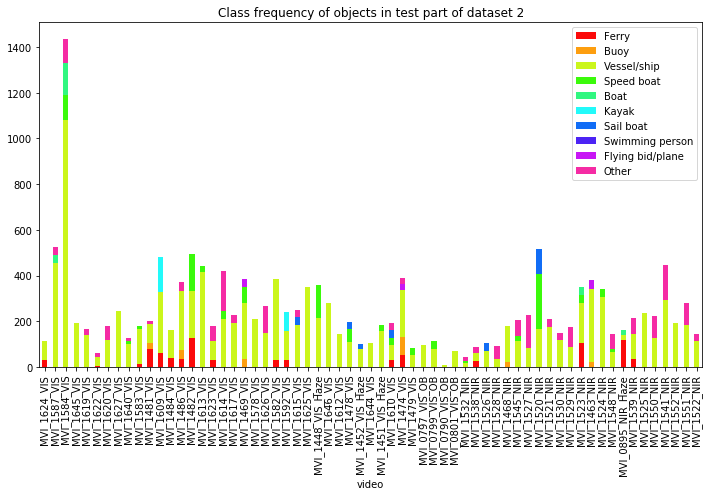

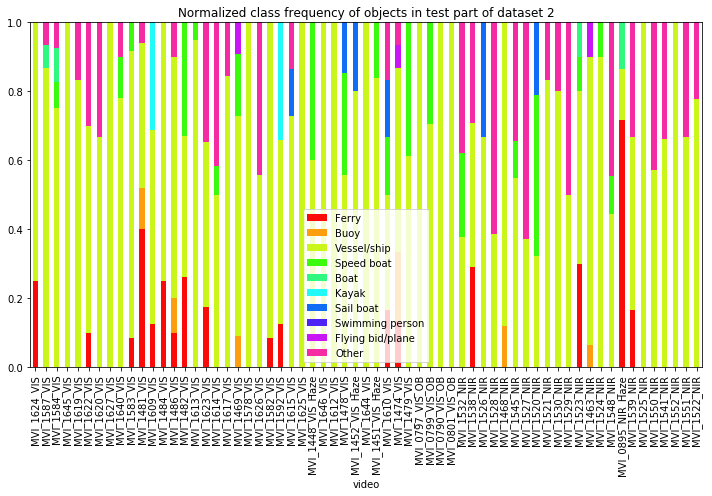

In [43]:
create_nice_bar_plot(test_objects, object_type_dict, 'Type', ['Video', 'Object type', 'Count'],
                    'Class frequency of objects in test part of dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_per_video_test.png'),
                    'Normalized class frequency of objects in test part of dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_per_video_test_normalized.png'))

MVI_1624_VIS  has  2  different entries:  [Ferry,Vessel/ship]
MVI_1587_VIS  has  3  different entries:  [Vessel/ship,Boat,Other]
MVI_1645_VIS  has  1  different entries:  [Vessel/ship]
MVI_1619_VIS  has  2  different entries:  [Vessel/ship,Other]
MVI_1622_VIS  has  3  different entries:  [Ferry,Vessel/ship,Other]
MVI_1620_VIS  has  2  different entries:  [Vessel/ship,Other]
MVI_1627_VIS  has  1  different entries:  [Vessel/ship]
MVI_1640_VIS  has  2  different entries:  [Vessel/ship,Speed boat]
MVI_1583_VIS  has  3  different entries:  [Ferry,Vessel/ship,Speed boat]
MVI_1481_VIS  has  4  different entries:  [Ferry,Buoy,Vessel/ship,Other]
MVI_1609_VIS  has  3  different entries:  [Ferry,Vessel/ship,Kayak]
MVI_1484_VIS  has  2  different entries:  [Ferry,Vessel/ship]
MVI_1486_VIS  has  4  different entries:  [Ferry,Buoy,Vessel/ship,Other]
MVI_1613_VIS  has  1  different entries:  [Vessel/ship]
MVI_1623_VIS  has  3  different entries:  [Ferry,Vessel/ship,Other]
MVI_1614_VIS  has  3  diffe

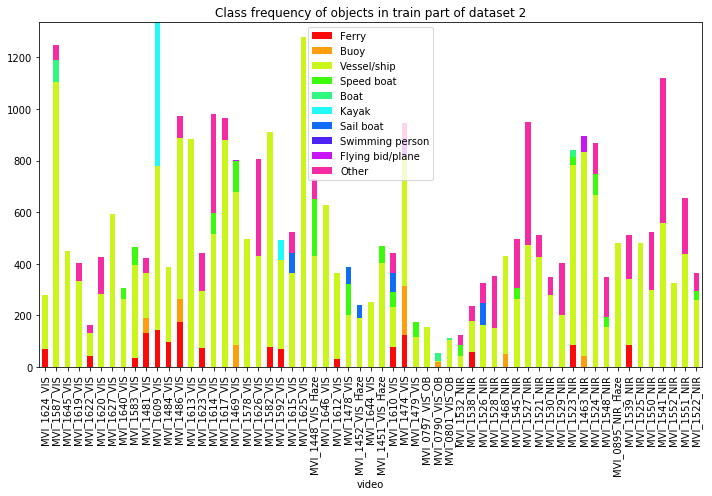

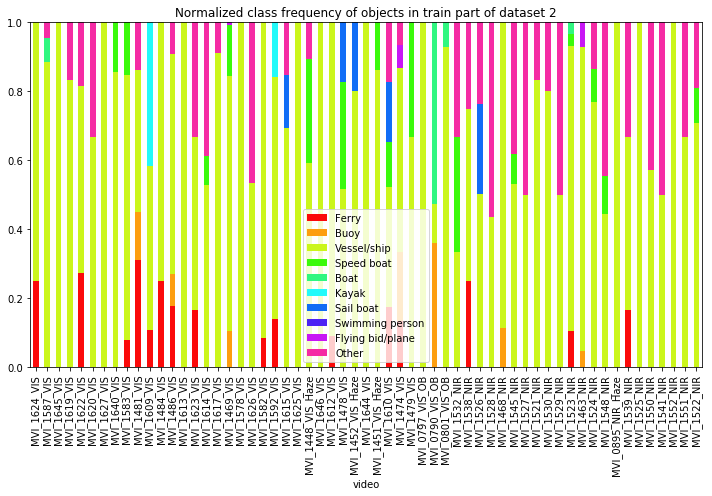

In [45]:
create_nice_bar_plot(train_objects, object_type_dict, 'Type', ['Video', 'Object type', 'Count'],
                    'Class frequency of objects in train part of dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_per_video_train.png'),
                    'Normalized class frequency of objects in train part of dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_per_video_train_normalized.png'))

# Now do the same for motion and distance

MVI_1624_VIS  has  1  different entries:  [Stationary]
MVI_1587_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1645_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1619_VIS  has  1  different entries:  [Moving]
MVI_1622_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1620_VIS  has  1  different entries:  [Moving]
MVI_1627_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1640_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1583_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1481_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1609_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1484_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1486_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1613_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1623_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1614_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1617_VIS  has  2  different entri

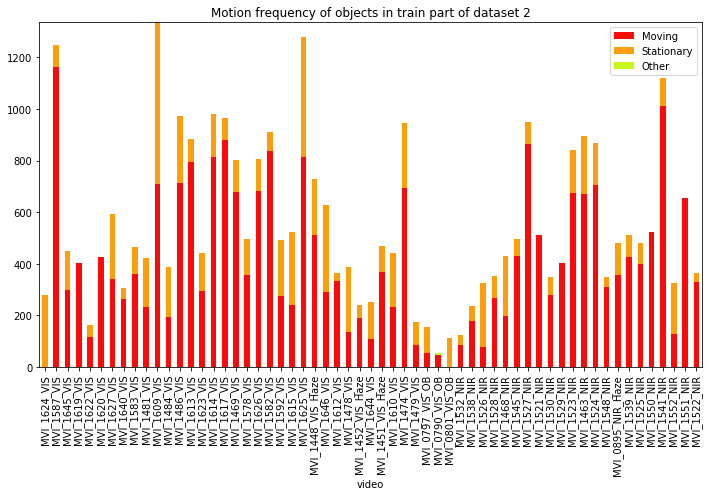

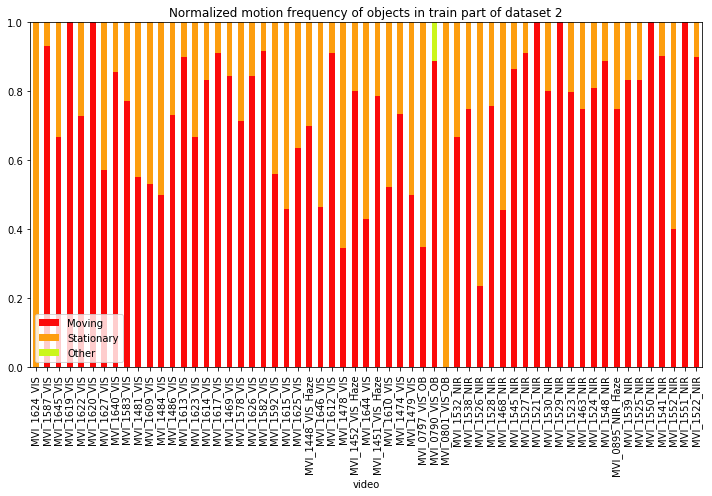

In [47]:
create_nice_bar_plot(train_objects, object_motion_dict, 'Motion', ['Video', 'Object motion', 'Count'],
                    'Motion frequency of objects in train part of dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_motion_per_video_train.png'),
                    'Normalized motion frequency of objects in train part of dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_motion_per_video_train_normalized.png'))

MVI_1624_VIS  has  1  different entries:  [Stationary,]
MVI_1587_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1645_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1619_VIS  has  1  different entries:  [Moving,]
MVI_1622_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1620_VIS  has  1  different entries:  [Moving,]
MVI_1627_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1640_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1583_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1481_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1609_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1484_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1486_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1613_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1623_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1614_VIS  has  2  different entries:  [Moving,Stationary,]
MVI_1617_VIS  has  2 

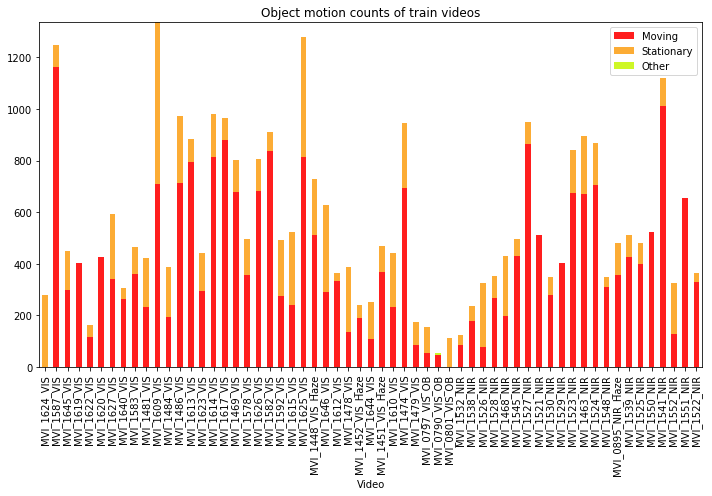

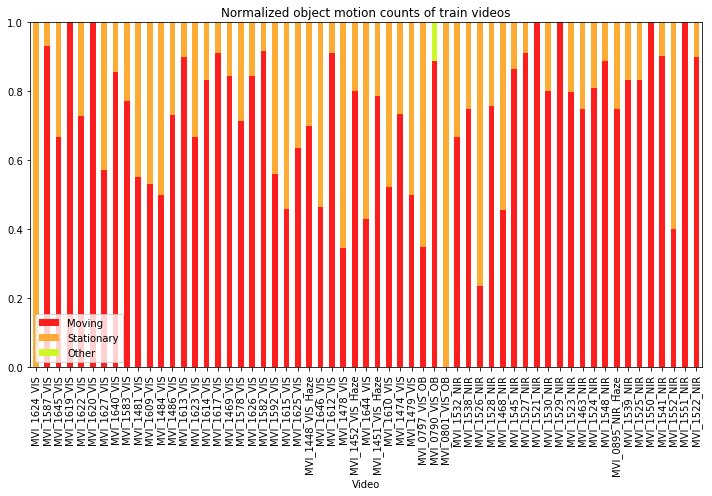

In [35]:
unique_videos = get_unique_videos_dict(train_objects)
unique_videos_object_types_dict = get_object_types_per_video_dictionary(unique_videos, 
                                                                        train_objects, 'Motion')
unique_videos_object_counts = get_video_object_count_dictionary(unique_videos_object_types_dict)
print_video_objects(unique_videos_object_counts, object_motion_dict)
unique_videos_object_counts = add_missing_types(unique_videos_object_counts, object_motion_dict)
df = convert_into_dataframe(unique_videos_object_counts, ['Video', 'Object motion', 'Count'], object_motion_dict)

plot_df_bar_chart(df,['Video', 'Object motion', 'Count'], 
                  'Object motion counts of train videos', 
                  os.path.join(FIGURE_SAVE_PATH, 'objects_motion_per_video_train.png'))

# normalized version:
unique_videos = get_unique_videos_dict(train_objects)
unique_videos_object_types_dict = get_object_types_per_video_dictionary(unique_videos, 
                                                                        train_objects, 'Motion')
unique_videos_object_counts = get_video_object_count_dictionary(unique_videos_object_types_dict, normalized=True)
#print_video_objects(unique_videos_object_counts)
unique_videos_object_counts = add_missing_types(unique_videos_object_counts, object_motion_dict)
df = convert_into_dataframe(unique_videos_object_counts, ['Video', 'Object motion', 'Count'], object_motion_dict)

plot_df_bar_chart(df,['Video', 'Object motion', 'Count'], 
                  'Normalized object motion counts of train videos', 
                  os.path.join(FIGURE_SAVE_PATH, 'objects_motion_per_video_train_normalized.png'))

MVI_1624_VIS  has  1  different entries:  [Stationary]
MVI_1587_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1584_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1645_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1619_VIS  has  1  different entries:  [Moving]
MVI_1622_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1620_VIS  has  1  different entries:  [Moving]
MVI_1627_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1640_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1583_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1481_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1609_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1484_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1486_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1482_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1613_VIS  has  2  different entries:  [Moving,Stationary]
MVI_1623_VIS  has  2  different entri

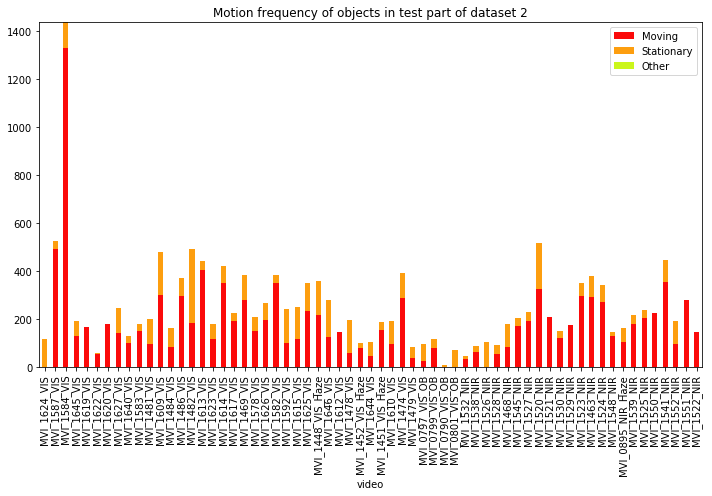

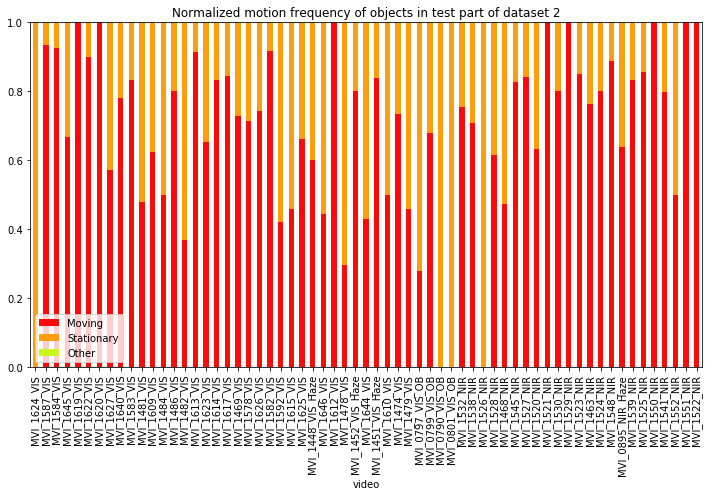

In [49]:
create_nice_bar_plot(test_objects, object_motion_dict, 'Motion', ['Video', 'Object motion', 'Count'],
                    'Motion frequency of objects in test part of dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_motion_per_video_test.png'),
                    'Normalized motion frequency of objects in test part of dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_motion_per_video_test_normalized.png'))

MVI_1624_VIS  has  1  different entries:  [Far]
MVI_1587_VIS  has  2  different entries:  [Near,Far]
MVI_1645_VIS  has  2  different entries:  [Near,Far]
MVI_1619_VIS  has  1  different entries:  [Far]
MVI_1622_VIS  has  2  different entries:  [Near,Far]
MVI_1620_VIS  has  1  different entries:  [Far]
MVI_1627_VIS  has  2  different entries:  [Near,Far]
MVI_1640_VIS  has  3  different entries:  [Near,Far,Other]
MVI_1583_VIS  has  1  different entries:  [Far]
MVI_1481_VIS  has  3  different entries:  [Near,Far,Other]
MVI_1609_VIS  has  2  different entries:  [Near,Far]
MVI_1484_VIS  has  1  different entries:  [Near]
MVI_1486_VIS  has  2  different entries:  [Near,Far]
MVI_1613_VIS  has  1  different entries:  [Far]
MVI_1623_VIS  has  1  different entries:  [Far]
MVI_1614_VIS  has  2  different entries:  [Near,Far]
MVI_1617_VIS  has  2  different entries:  [Far,Other]
MVI_1469_VIS  has  2  different entries:  [Near,Far]
MVI_1578_VIS  has  1  different entries:  [Far]
MVI_1626_VIS  has  

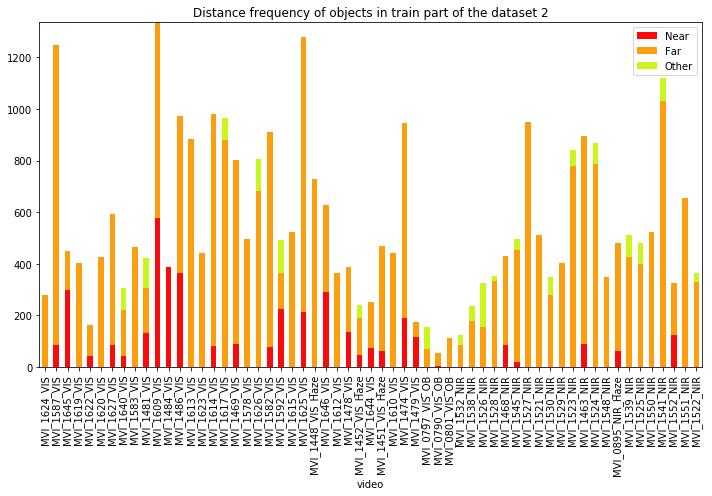

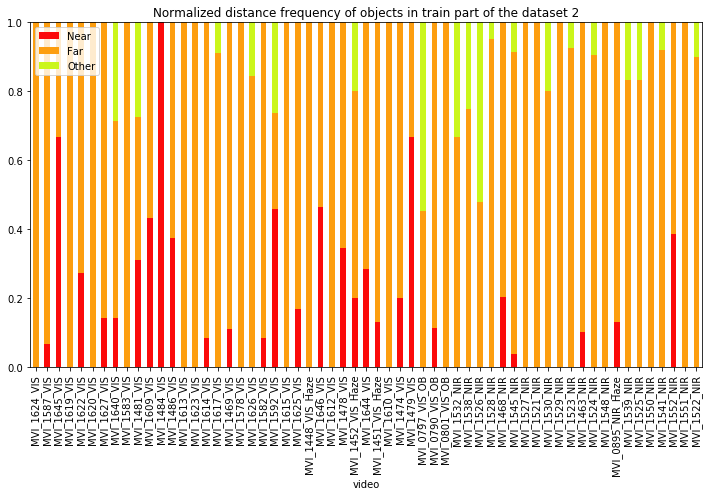

In [50]:
create_nice_bar_plot(train_objects, object_distance_dict, 'Distance', ['Video', 'Object distance', 'Count'],
                    'Distance frequency of objects in train part of the dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_distance_per_video_train.png'),
                    'Normalized distance frequency of objects in train part of the dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_distance_per_video_train_normalized.png'))

MVI_1624_VIS  has  1  different entries:  [Far]
MVI_1587_VIS  has  2  different entries:  [Near,Far]
MVI_1584_VIS  has  1  different entries:  [Far]
MVI_1645_VIS  has  2  different entries:  [Near,Far]
MVI_1619_VIS  has  1  different entries:  [Far]
MVI_1622_VIS  has  2  different entries:  [Near,Far]
MVI_1620_VIS  has  1  different entries:  [Far]
MVI_1627_VIS  has  2  different entries:  [Near,Far]
MVI_1640_VIS  has  3  different entries:  [Near,Far,Other]
MVI_1583_VIS  has  1  different entries:  [Far]
MVI_1481_VIS  has  3  different entries:  [Near,Far,Other]
MVI_1609_VIS  has  2  different entries:  [Near,Far]
MVI_1484_VIS  has  1  different entries:  [Near]
MVI_1486_VIS  has  2  different entries:  [Near,Far]
MVI_1482_VIS  has  2  different entries:  [Near,Far]
MVI_1613_VIS  has  1  different entries:  [Far]
MVI_1623_VIS  has  1  different entries:  [Far]
MVI_1614_VIS  has  2  different entries:  [Near,Far]
MVI_1617_VIS  has  2  different entries:  [Far,Other]
MVI_1469_VIS  has  

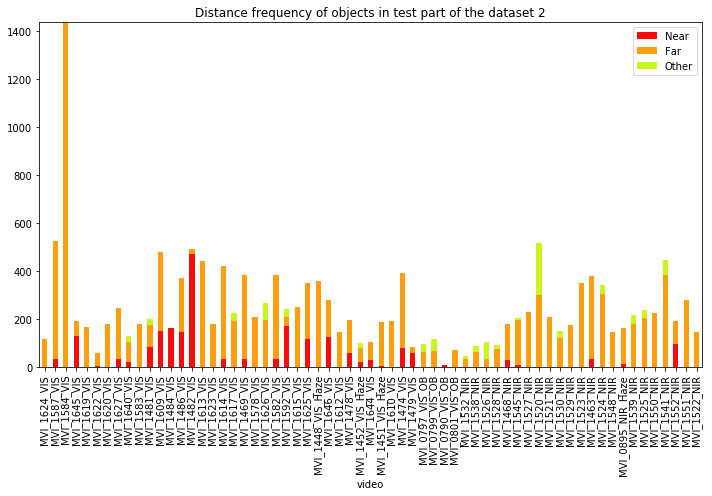

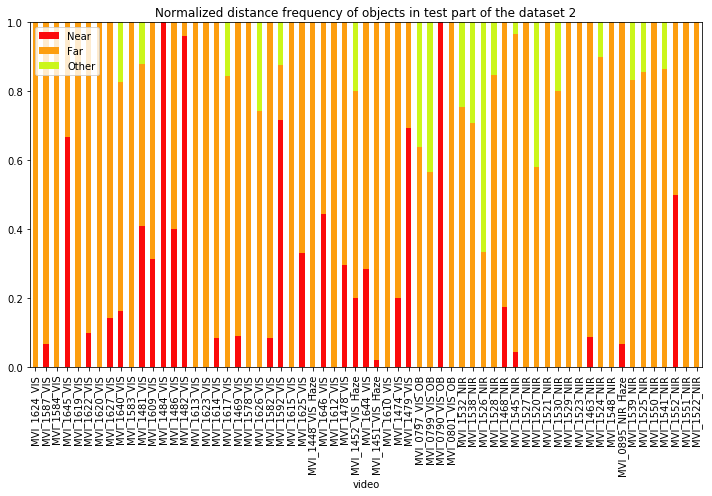

In [51]:
create_nice_bar_plot(test_objects, object_distance_dict, 'Distance', ['Video', 'Object distance', 'Count'],
                    'Distance frequency of objects in test part of the dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_distance_per_video_test.png'),
                    'Normalized distance frequency of objects in test part of the dataset 2',
                    os.path.join(FIGURE_SAVE_PATH, 'objects_distance_per_video_test_normalized.png'))

# Statistics of objects and the number of videos they appear

In this statistic we will count the number of videos each object appears. Each video will be counted if the object appears in at least one frame.

In [52]:
unique_videos = get_unique_videos_dict(train_objects + test_objects)
unique_videos_object_types_dict = get_object_types_per_video_dictionary(unique_videos, 
                                                                        train_objects + test_objects, 'Type')
unique_videos_object_counts = get_video_object_count_dictionary(unique_videos_object_types_dict)

objects_in_videos_count_dictionary = {}

for video, objects_list in unique_videos_object_counts.items():
    object_types, object_counts = objects_list
    for object_type in object_types:
        if not object_type in objects_in_videos_count_dictionary:
            objects_in_videos_count_dictionary[object_type] = 1
        else:
            objects_in_videos_count_dictionary[object_type] += 1

for object_type, video_count in objects_in_videos_count_dictionary.items():
    print(object_type_dict[object_type], ' appears in ', video_count, ' different videos.')

Ferry  appears in  18  different videos.
Vessel/ship  appears in  63  different videos.
Boat  appears in  6  different videos.
Other  appears in  32  different videos.
Speed boat  appears in  20  different videos.
Buoy  appears in  7  different videos.
Kayak  appears in  2  different videos.
Flying bid/plane  appears in  3  different videos.
Sail boat  appears in  6  different videos.


# Generate Heatmaps

In [53]:
def get_dataframe(objects_data, 
                         object_dict,  
                         data_column='Type',
                         dataframe_columns=['Video', 'Object type', 'Count']):
    
    """
    Converts the given objects list into a pandas dataframe.
    
    Parameters:
    
    objects_data : the list of the relative object entries in the form:
            MVI_0797_VIS_OB_frame0.jpg,1327.534834324554,459.75233644859804,161.49532710280369,42.412914188615105,3,2,1
            
    object_dict : list of csv entries. Each entry is of the form:
            [<video_name>_<frame_number>.jpg, 
            x_min, 
            y_min, 
            object width, 
            object height, 
            type of object, 
            distance of object, 
            type of motion of object]
            
            This file is generated from the ground truth files using another script.
            
    data_column : the column of object to export. String
            Valid values: ['Type','Motion','Distance']
    
    dataframe_columns : list of the column header. Example: ['Video', 'Object type', 'Count']
    
    Returns
    -------
    
    df : the corresponding pandas dataframe
    """
    
    unique_videos = get_unique_videos_dict(objects_data)
    unique_videos_object_types_dict = get_object_types_per_video_dictionary(unique_videos, 
                                                                            objects_data, data_column)
    unique_videos_object_counts = get_video_object_count_dictionary(unique_videos_object_types_dict)
    #print_video_objects(unique_videos_object_counts, object_dict)
    unique_videos_object_counts = add_missing_types(unique_videos_object_counts, object_dict)
    df = convert_into_dataframe(unique_videos_object_counts, dataframe_columns, object_dict)

    return df

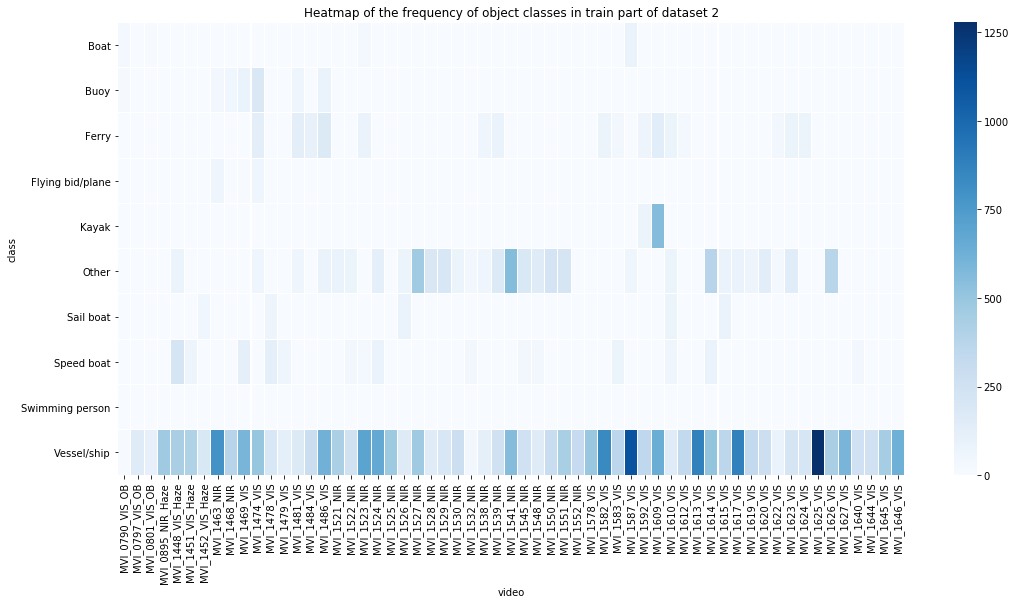

In [55]:
import seaborn as sns

df = get_dataframe(train_objects, 
                   object_type_dict, 
                   'Type', 
                   ['Video', 'Object type', 'Count'])
               
df = df.pivot('Object type','Video', 'Count')
fig = plt.figure()
fig.set_size_inches(15.5, 8.5)

ax = sns.heatmap(df, linewidth=0.01, cmap='Blues',xticklabels=True, yticklabels=True)
plt.title('Heatmap of the frequency of object classes in train part of dataset 2')
plt.tight_layout()
ax.set_ylabel('class')
ax.set_xlabel('video')
plt.savefig(os.path.join(FIGURE_SAVE_PATH ,'heatmap_objects_train.png'), tight_layout=True, dpi=300)
plt.show()

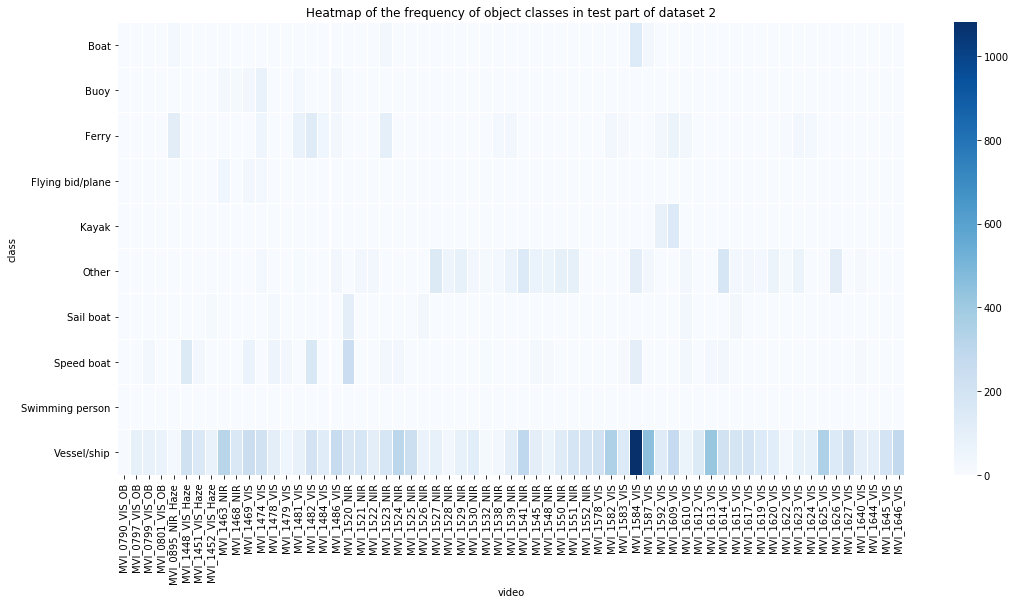

In [56]:
df = get_dataframe(test_objects, 
                   object_type_dict, 
                   'Type', 
                   ['Video', 'Object type', 'Count'])
                   
df = df.pivot('Object type','Video', 'Count')
fig = plt.figure()
fig.set_size_inches(15.5, 8.5)

ax = sns.heatmap(df, linewidth=0.01, cmap='Blues',xticklabels=True, yticklabels=True)
plt.title('Heatmap of the frequency of object classes in test part of dataset 2')
plt.tight_layout()
ax.set_ylabel('class')
ax.set_xlabel('video')
plt.savefig(os.path.join(FIGURE_SAVE_PATH ,'heatmap_objects_test.png'), tight_layout=True, dpi=300)
plt.show()

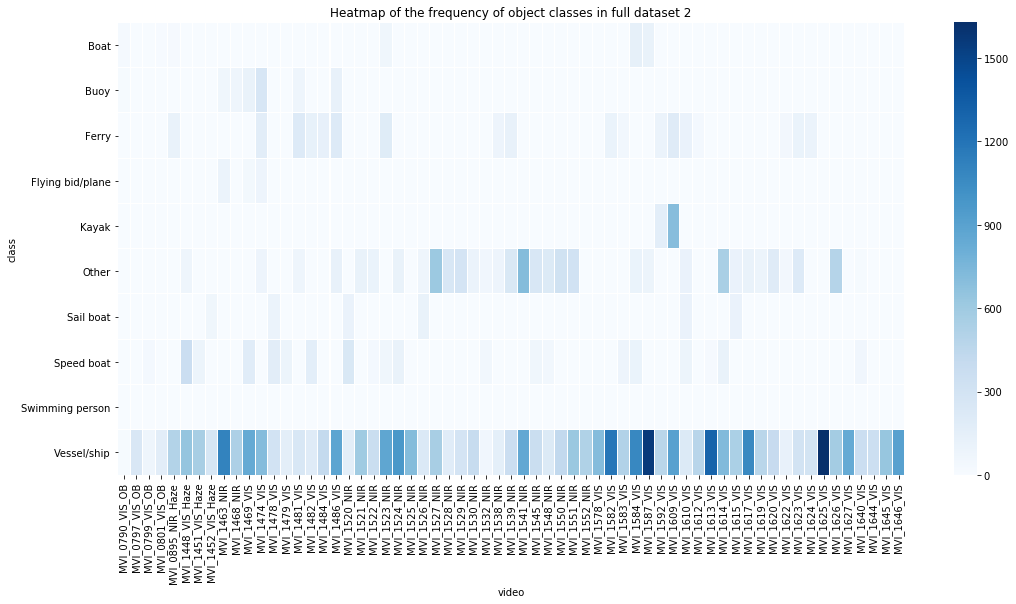

In [57]:
# get a heatmap for all dataset

df = get_dataframe(train_objects + test_objects, 
                   object_type_dict, 
                   'Type', 
                   ['Video', 'Object type', 'Count'])
             
df = df.pivot('Object type','Video', 'Count')
fig = plt.figure()
fig.set_size_inches(15.5, 8.5)

ax = sns.heatmap(df, linewidth=0.01, cmap='Blues',xticklabels=True, yticklabels=True)
plt.title('Heatmap of the frequency of object classes in full dataset 2')
plt.tight_layout()
ax.set_ylabel('class')
ax.set_xlabel('video')
plt.savefig(os.path.join(FIGURE_SAVE_PATH ,'heatmap_objects_full_dataset.png'), tight_layout=True, dpi=300)
plt.show()